# Task 4: Classification

_All credit for the code examples of this notebook goes to the book "Hands-On Machine Learning with Scikit-Learn & TensorFlow" by A. Geron. Modifications were made and text was added by K. Zoch in preparation for the hands-on sessions._

# Setup

First, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function to save a figure. This also decides that all output files 
# should stored in the subdirectorz 'classification'.
PROJECT_ROOT_DIR = "."
EXERCISE = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "output", EXERCISE, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Preparing the dataset

Define a function to sort the dataset into the 'targets' train and test data. This is needed because we want to use the same 60,000 data points for training, and the sam e10,000 data points for testing on every machine (and the dataset provided through Scikit-Learn is already prepared in this way).

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

Now fetch the dataset using the SciKit-Learn function (this might take a moment ...).

In [3]:
# We need this try/except for different Scikit-Learn versions.
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Let's have a look at what the 'data' key contains: it is a numpy array with one row per instance and one column per feature.

In [4]:
mnist["data"]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

And the same for the 'target' key which is an array of labels.

In [5]:
mnist["target"]

array([0, 0, 0, ..., 9, 9, 9], dtype=int8)

Now, let's first define the more useful `x` and `y` aliases for the data and target keys, and let's have a look at the type of data using the `shape` function: we see 70,000 entries in the data array, with 784 features each. The 784 correspond to 28x28 pixels of an image with brightness values between 0 and 255. 

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape  # get some information about its shape

(70000, 784)

In [7]:
28*28    # just a little cross-check we're doing the correct arithmetics here ...

784

In [8]:
X[36000][160:200]  # Plot brightness values [160:200] of the random image X[36000].

array([131., 225., 225., 225.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  13.,  73., 197., 253., 252., 252., 252., 252.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.])

Now let's have a look at one of the images. We just pick a random image and use the `numpy.reshape()` function to reshape it into an array of 28x28 pixels. Then we can plot it with `matplotlib.pyplot.imshow()`:

Saving figure some_digit_plot


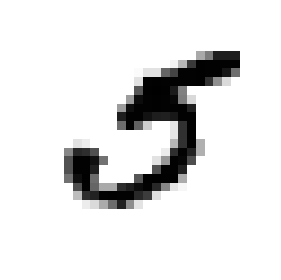

In [9]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

Let's quickly define a function to plot one of the digits, we will need it later down the line. It might also be useful to have a function to plot multiple digits in a batch (we will also use this function later). The following two cells will not produce any output.

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [11]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Great, now we can plot multiple digits at once. Let's ignore the details of the `np.r_[]` function and the indexing used within it for now and focus on what it does: it takes ten examples of each digit from the data array, which we can then plot with our `plot_digits()` function.

Saving figure more_digits_plot


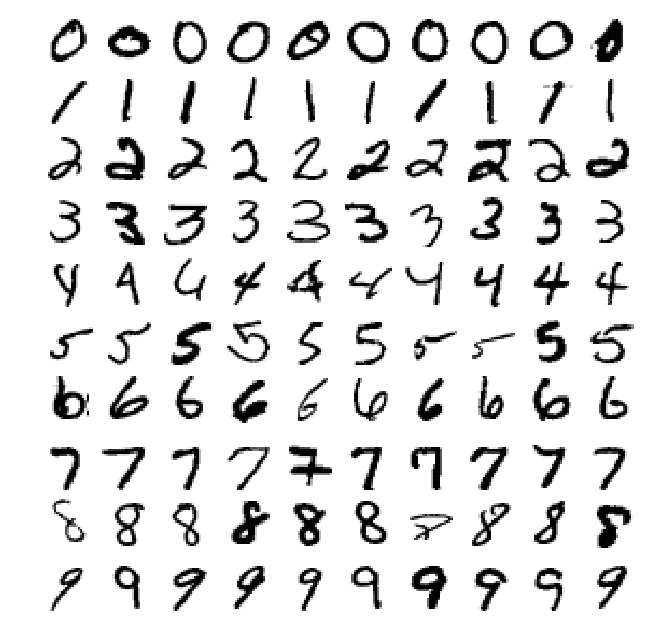

In [12]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

Ok, at this point we have a fairly good idea how our data array looks like: we have an array of 70,000 images with 28x28 pixels each. The entries in the array are sorted according to ascending digits, i.e. it starts with images of zeros and ends with images of nines at entry 59,999. Entries `x[60000:]` onwards are meant to be used for testing and again contain images of all digits in ascending order.

Before starting with binary classification, let's quickly confirm that the labels stored in `y` actually make sense. We previously looked at entry `X[36000]` and it looked like a five. Does `y[36000]` say the same?

In [13]:
y[36000]

5

Good! As a very last step, let's split train and test and store them separately. Because we also don't want our training to be biased, we should shuffle the entries randomly (i.e. not sort them in ascending order anymore). We can do this with the `np.random.permutation(60000)` function which returns a random permutation of the numbers between zero and 60,000.

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [15]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary classifier

Before going towards a classifier, which can distinguish _all_ digits, let's start with something simple. Since our random digit `X[36000]` was a five, why not design a classifier that can distinguish fives from other digits? Let's first rewrite our labels from integers to booleans:

In [16]:
y_train_5 = (y_train == 5)   # an array of booleans which is 'True' whenever y_train is == 5
y_test_5 = (y_test == 5)
y_train_5                    # let's look at the array

array([False, False, False, ..., False, False, False])

A good model for the classification is the Stochastic Gradient Descent that was introduced in the lecture. Conveniently, Skiki-Learn already has such a classifier implemented, so let's import it and give it our training data `X_train` with the true labels `y_train_5`.

In [17]:
from sklearn.linear_model import SGDClassifier

# SDG relies on randomness, but by fixing the `random_state` we can get reproducible results.
# The other values are just to avoid a warning issued by Skikit-Learn ...
sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=-np.infty)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

If the training of the classifier was successful, it should be able to predict the label of our example instance `X[36000]` correctly.

In [18]:
sgd_clf.predict([some_digit])

array([ True])

That's good, but it doesn't really give us an idea about the overall performance of the classifier. One good measure for this introduced in the lecture is the cross-validation score. In k-fold cross-validation, the training data is split into k equal subsets. Then the classifier is trained on k-1 sets and evaluated on set k. It's called cross-validation, because this is done for all k possible (and non-redundant) permutations. In case of a 3-fold, this means we train on subsets 1 and 2 and validated on 3, train on 1 and 3 and validate on 2, and train on 2 and 3 and validate on 1. The _score_ represents the prediction accuracy on the validation fold.

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

While these numbers seem amazingly good, keep in mind, that only 10% of our training data are images of fives, so even a classifier which always predicts 'not five' would reach an accuracy of about 90% ...

In the following box, maybe you can try to implement the cross validation yourself! The `StratifiedKFold` creates k non-biased subsets of the training data. The input to the `StratifiedKFold.split(X, y)` are the training data `X` (in our case called `X_train`) and the labels (in our case for the five-classifier `y_train_5`). The `sklearn.base.clone` function will help to make a copy of the classifier object.

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_indices, test_indices in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)   # make a clone of the classifier
    # [...] some code is missing here
    X_train_folds = X_train[train_indices]
    y_train_folds = y_train_5[train_indices]
    clone_clf.fit(X_train_folds, y_train_folds)
    
    X_test_fold = X_train[test_indices]
    y_test_fold = y_train_5[test_indices]
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print("Fraction of correct predictions: %s" % (n_correct / len(y_pred)))

Fraction of correct predictions: 0.9502
Fraction of correct predictions: 0.96565
Fraction of correct predictions: 0.96495


Let's move on to another performance measure: the confusion matrix. The confusion matrix is a 2x2 matrix and includes the number of true positives, false positives (type-I error), true negatives and false negatives (type-II error). First, let's use another of Scitkit-Learn's functions: `cross_val_predict` takes our classifier, our training data and our true labels, and automatically performs a k-fold cross-validation. It returns an array of the predicted labels.

In [21]:
from sklearn.model_selection import cross_val_predict

# Take our SGD classifer and perform a 3-fold cross-validation.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Print some of the predicted labels.
print(y_train_pred)

[False False False ... False False False]


Using cross-validation always gives us a 'clean', i.e. unbiased estimate of our prediction power, because the performance of the classifier is evaluated on data it hadn't seen during training. Now we have our predicted labels in `y_train_pred` and can compare them to the true labels `y_train_5`. So let's create a confusion matrix.

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

How do we read this? The rows correspond to the _true_ classes, the columns to the _predicted_ classes. So the 53,272 means that about fifty-three thousand numbers that are 'not five' were predicted as such, while 1307 were predicted to be fives. 4344 true fives were predicted to be fives, but 1077 were not. Sometimes it makes sense to normalise the confusion matrix by rows, so that the values in the cells give an idea how large the _fraction_ of correctly and incorrectly predicted instances is. So let's try this:

In [23]:
matrix = confusion_matrix(y_train_5, y_train_pred)
row_sums = matrix.sum(axis=1)
matrix / row_sums[:, np.newaxis]

array([[0.97605306, 0.02394694],
       [0.19867183, 0.80132817]])

There are other metrics to evaluate the performance of classifiers as we saw in the lecture. One example is the _precision_ which is the rate of true positives among all positives. The precision is a measure how many of our predicted positives are _actually_ positives, i.e. it can be calculated as TP / (TP + FP) (TP = true positives, FP = false positives).

In [24]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))

# Can you reproduce this value by hand? All info should be in the confusion matrix.
tp = matrix[1][1]
fp = matrix[0][1]
precision_by_hand = tp / (tp + fp)
print("By hand: %s" % precision_by_hand)

0.7687135020350381
By hand: 0.7687135020350381


Or in words: 77% of our predicted fives are _actually_ fives, while 23% of the predicted fives are other numbers.

Another metric, which is often used in conjunction with the _precision_, is the _recall_. The recall is a measure of how many of the true positives as predicted as such, i.e. "how many true positives do we identify". It is easy to reach perfect precision if you just make your classifier reject all negatives, but it's impossible to keep a high recall score in that case. Let's look at our classifier's recall:

In [25]:
print(recall_score(y_train_5, y_train_pred))

# Again, it should be straight-forward to make this calculation by hand. Can you try?
tp = matrix[1][1]
fn = matrix[1][0]
recall_by_hand = tp / (tp + fn)
print("By hand: %s" % recall_by_hand)

0.801328168234643
By hand: 0.801328168234643


In words: only 80% of the fives are correctly predicted to be fives. Doesn't look as great as the 95% prediction rate, does it? A nice combination for precision and recall is their harmonic mean, usually known (and in the lecture introduced as) the _F_1 score_. The harmonic mean (as opposed to the arithmetic mean) is very sensitive low values, so only a good balance between precision and recall will lead to a high F_1 score. Very conveniently, Scikit-Learn comes with an implementation of the score already, but can you also calculate it by hand?

In [26]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

# Once more, it is fairly easy to calculate this by hand. Give it a try!
f1_score_by_hand = 2 / (1/precision_by_hand + 1/recall_by_hand)
print("By hand: %s" % f1_score_by_hand)

0.7846820809248555
By hand: 0.7846820809248556


Of course, a balanced precision and recall is not _always_ desirable. Whether you want both to be equally high, depends on the use case. Sometimes, you'd definitely want to classify as many true positives as such, with the tradeoff to have low precision (example: in a test for a virus you want every true positive to know that they might be infected, but you might get a few false positives). In other cases, you might want a high precision with the tradeoff that you don't detect all positives as such (example: it's ok to remove some harmless videos in a video filter, but you don't want harmful content to pass your filter).

## Decision function

When we use the `predict()` function, our classifier gives a boolean prediction. But how is that prediction done? The classifier calculates a score, called 'decision_function' in Scikit-Learn, and any instance above a certain threshold is classified as 'true', any instance below as 'false'. By retrieving the decision function directly, we can look at different tradeoffs between precision and recall.

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
print(y_scores)   # Print scores to get an idea ...

[ -434076.49813641 -1825667.15281624  -767086.76186905 ...
  -867191.25267994  -565357.11420164  -366599.16018198]


This again gives us a numpy array with 60,000 entries, all of which contain a floating point value with the predicted score. Now, as we've seen before, Scikit-Learn provides many functions out-of-the-box to evaluate classifiers. The following `precision_recall_curve` metric gives us tuples of precision, recall and threshold values based on our training data. It takes the true labels, in our case `y_train_5` and the `y_scores` to calculate these. We can then use thes values to plot curves for precision and recall for different threshold values.

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions)

[0.09080706 0.09079183 0.09079335 ... 1.         1.         1.        ]


Saving figure precision_recall_vs_threshold_plot


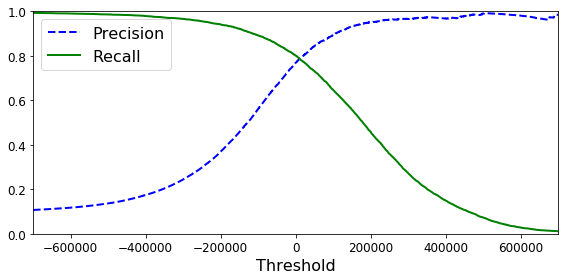

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Looks good! Bonus question: why is the precision curve bumpier than the recall?

Let's assume we want to optimise our classfier for a precision value of 93%. Can you find a good threshold? The below threshold is just a test value and definitely too low. 

In [30]:
threshold = -20000
y_train_pred_93 = (y_scores > threshold)
print("precision: %s" % precision_score(y_train_5, y_train_pred_93))
print("recall:    %s" % recall_score(y_train_5, y_train_pred_93))

precision: 0.7297430021280079
recall:    0.8223574986164914


Sometimes, plotting precision vs. recall can also be helpful.

Saving figure precision_vs_recall_plot


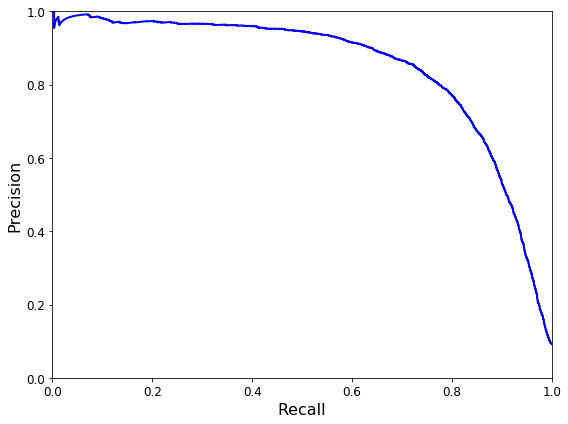

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

# ROC curves

Because it's an extremely common performance measure, we should also have a look at the ROC curve (_receiver operating characteristic_). ROC curves plot true positives vs. false positives, or usually the true positive _rate_ vs. the false positive _rate_. While the first is exactly what we called _recall_ so far, the latter is one minus the _true negative rate_, also called specificity. Let's import the ROC curve from Scikit-Learn, this will give us tuples of FPR, TPR and threshold values again.

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Now we can plot them:

Saving figure roc_curve_plot


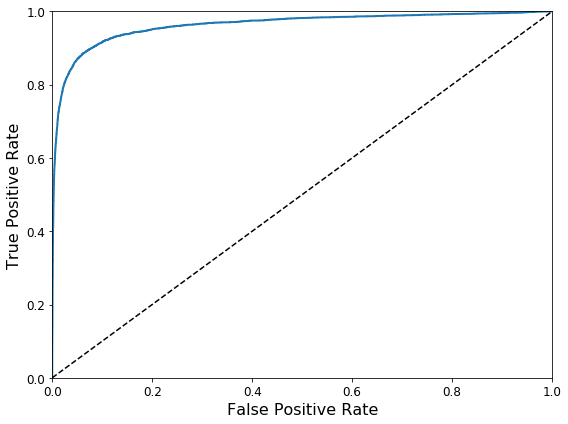

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

It is always desirable to have the curve as close to the top left corner as above. As a measure for this, one usually calculates the _area under curve_. What is the AUC value for a random classifier?

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

# Multiclass classification

So far we have completely ignored the fact that our training data not only includes fives and 'other digits', but in fact ten different input labels (one for each digit). Multiclass classification will allow us to distinguish each of them individually and predict the _most likely class_ for each instance. Scikit-Learn is clever enough to realise, that our label array `y_train` contains ten different classes, so – without explicitly telling us – it runs ten binary classifiers when we call the `fit()` function on the SGD classifier. Each of these binary classifiers trains one class vs. all others ("one-versus-all"). Let's try it out:

In [35]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

How does it classify our previous example of something that looked like a five?

In [36]:
sgd_clf.predict([some_digit])

array([5], dtype=int8)

Great! But what exactly happens under the hood? It actually calculates ten different scores for the ten different binary classifiers and picks the class with the highest score. We can see this by calling the `decision_function()` as we did earlier:

In [37]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)              # Print us the array content
print("Largest entry: %s" % np.argmax(some_digit_scores))   # Get the index of the largest entry

[[-311402.62954431 -363517.28355739 -446449.5306454  -183226.61023518
  -414337.15339485  161855.74572176 -452576.39616343 -471957.14962573
  -518542.33997148 -536774.63961222]]
Largest entry: 5


Scikit-Learn even comes with a class to run the one-versus-one approach as well. We can just give it our SGD classifier instance and then call the `fit()` function on it:

In [38]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(sgd_clf)
ovo_clf.fit(X_train, y_train)

# What does it predict for our random five?
ovo_clf.predict([some_digit])

array([5], dtype=int8)

And how many classifiers does this one-versus-one approach need? Can you come up with the formula?

In [39]:
print("Number of estimators: %s" % len(ovo_clf.estimators_))

Number of estimators: 45


Back to the one-versus-all approach – how good are we? For that, we can calculate the cross-validation score once more to get values for the accuracy. Bear in mind that now we are running a _ten-class_ classification!

In [40]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

This is not bad at all, although you could probably spend hours optimising the hyperparameters of this model. How good does the onve-versus-one approach perform? Try it out!

Let's look at some other performance measures for the one-versus-all classifier. A good point to start is the confusing matrix.

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train_pred, y_train)
conf_mx

array([[5604,    1,   59,   40,   24,   73,   50,   65,   47,   58],
       [   2, 6292,   73,   16,   26,   25,   19,   19,   96,   45],
       [  81,   72, 5016,  148,  145,   74,  128,   69,  127,   59],
       [  25,   54,  218, 5315,   39,  375,   13,  117,  196,  199],
       [   8,   20,   68,   19, 4746,   62,   84,  100,   77,  233],
       [  44,   22,   25,  199,   22, 3868,  105,   18,  135,   59],
       [  32,    8,   82,   23,   63,   91, 5369,    2,   30,    2],
       [   9,    8,   58,   41,   49,   22,    8, 5641,   23,  385],
       [ 115,  262,  344,  297,  502,  771,  140,  112, 5088,  725],
       [   3,    3,   15,   33,  226,   60,    2,  122,   32, 4184]])

Ok, maybe it's better to display this in a plot:

Saving figure confusion_matrix_plot


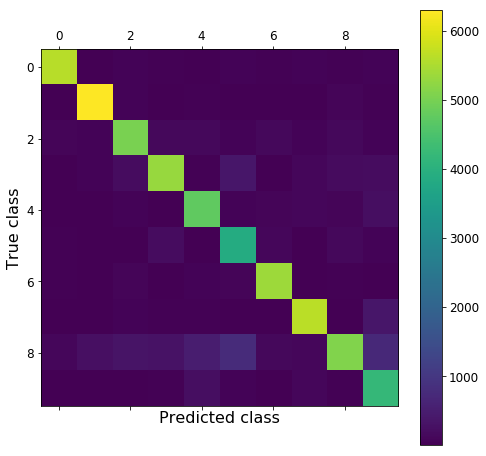

In [42]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlabel('Predicted class', fontsize=16)
    plt.ylabel('True class', fontsize=16)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(conf_mx)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

It's still very hard to see what's going on. So maybe we should (1) normalise the matrix by rows again, (2) "remove" all diagonal entries, because those are not interesting for us for the error analysis.

Saving figure confusion_matrix_errors_plot


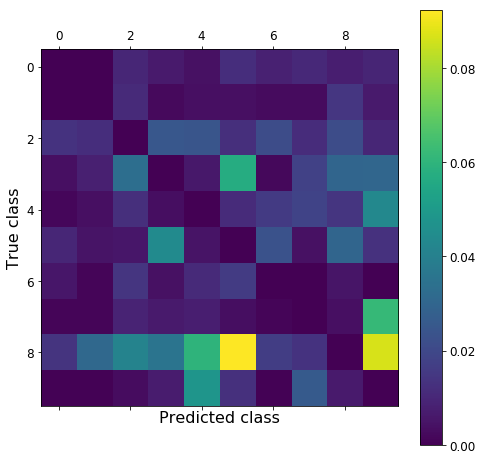

In [43]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

It seems we're predicting many of the eights wrong. In particular, many of them are predicted to be a five! On the other hand, not many fives are misclassified as eights. Interesting, right? Let's pick out some eights and fives, each of which are either correctly predicted, or predicted as the other class. Maybe looking at the pictures with our "human learning" algorithm will see the problem.

Saving figure error_analysis_digits_plot


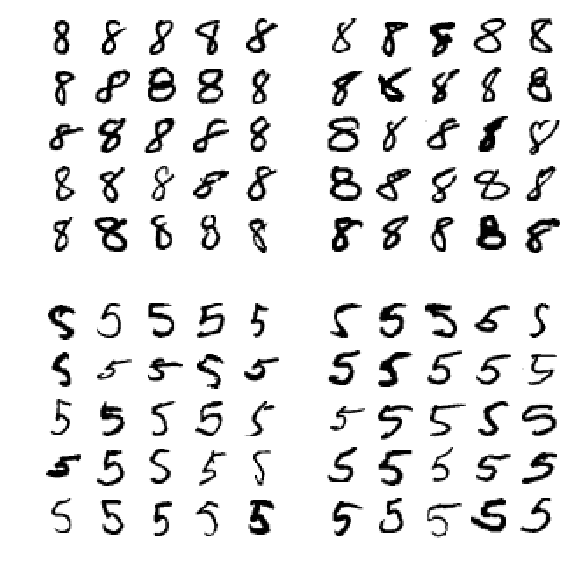

In [44]:
cl_a, cl_b = 8, 5   # Define class a and class b for the plot

# Training data from class a, which is predicted as a.
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]

# Training data from class a, which is predicted as b.
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]

# Training data from class b, which is predicted as a.
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

# Training data from class b, which is predicted as b.
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()